#### 1. Overview of functional code for perception and naviagtion according to the line of the roads and vehocle in front:

Following software architecture is applied in this file:
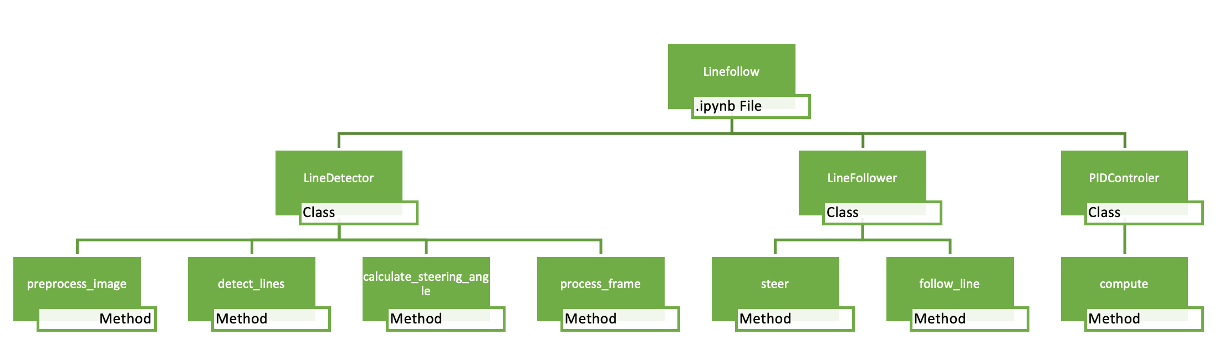


The call architecture is designed to use according to the illustration bellow:
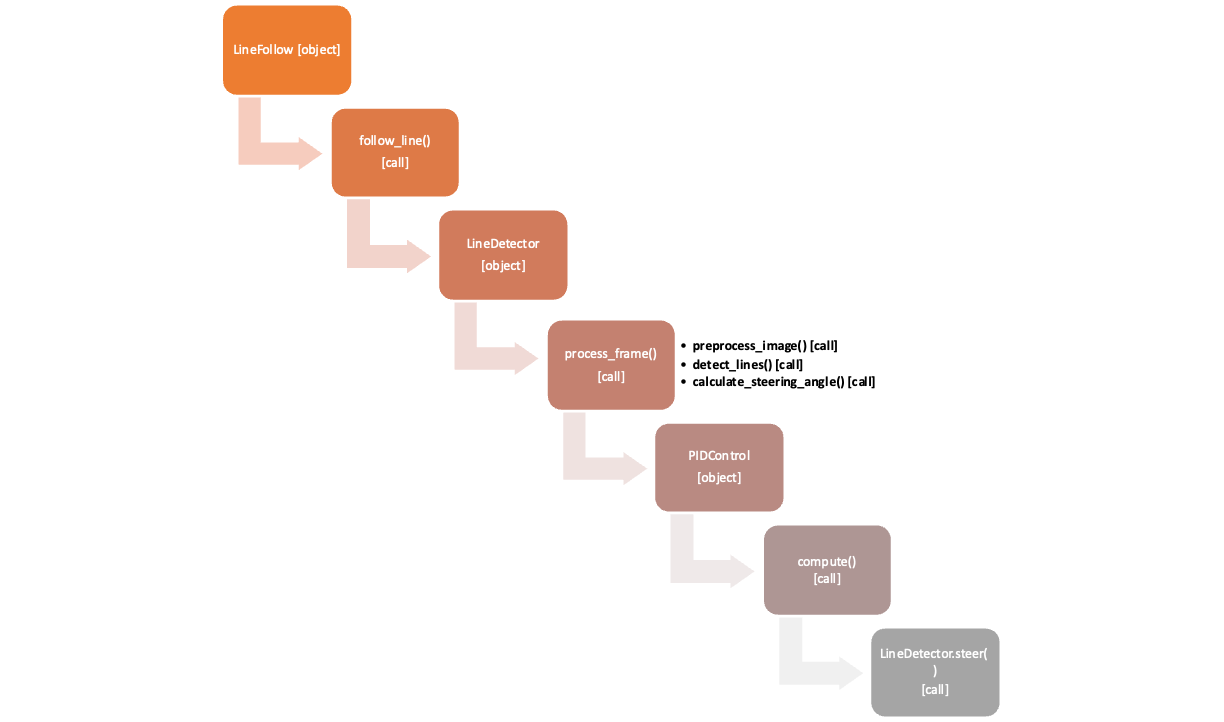


this code was developped in Jupyter-Notebook, Google collab and VS studio. Tools from IDE were used to correct and improve code like VS-Code auttocorrection and copilot education license. 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
from datetime import datetime  # For timestamps
import time  # Additional import that might be useful for delays
import numpy as np
from jetbot import Robot, Camera
import pyzbar.pyzbar as pyzbar
from pyzbar.pyzbar import decode


class LineDetector:
    def __init__(self, camera, width=224, height=224, save_dir='images_collection' ):
        self.camera = camera
        # Just if you want to use camera direct here, will be set from outside
        #self.camera = Camera.instance(width=width, height=height)
        self.image_height = height
        self.image_width = width
        # save images if needed
        self.save_dir = save_dir
        
        # if direction does not exist, create direction here
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            os.makedirs(os.path.join(save_dir, 'original'))
            os.makedirs(os.path.join(save_dir, 'processed'))
            
    def preprocess_image_qrcode(self,image):
        # Resize the image for better detection
        resized_image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

        # Convert to grayscale
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Apply a sharpening kernel
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        sharpened_image = cv2.filter2D(gray_image, -1, kernel)

        # Apply adaptive histogram equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(sharpened_image)

        return enhanced_image
    
    def detect_large_blue_rectangle(self, debug=False):
        """
        Detects the largest blue rectangle in the camera feed.

        Parameters:
        camera_feed (numpy.ndarray): Input image frame from the camera.

        Returns:
        tuple: (boolean, center_x)
            - boolean: True if a large blue rectangle (>detection_threshold of image) is detected, False otherwise.
            - center_x: The x-coordinate of the center of the largest rectangle if detected, None otherwise.
        """
        # Define the lower and upper bounds for the color blue in HSV
        lower_blue = np.array([100, 80, 50])
        upper_blue = np.array([140, 255, 255])

        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(self.camera.value, cv2.COLOR_BGR2HSV)

        # Create a mask for blue color
        mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

        # Find contours in the blue mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize variables to store the largest rectangle's properties
        largest_area = 0
        largest_center_x = None
        image_area = 50176
        detection_threshold = 0.01
        
        annotated_image = self.camera.value.copy()

        for contour in contours:
            # Approximate the contour to a polygon and find its bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            # Check if the current rectangle is the largest and blue
            if area > largest_area:
                largest_area = area
                largest_center_x = x + w // 2
                cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
        if debug:
            # Display the original feed, mask, and annotated image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.title("Camera Feed")
            plt.imshow(cv2.cvtColor(self.camera.value, cv2.COLOR_BGR2RGB))
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Blue Mask")
            plt.imshow(mask, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Annotated Image")
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.axis("off")

            plt.show()

        # Check if the largest blue rectangle covers more than 20% of the image
        if largest_area / image_area > detection_threshold:
            return True, largest_center_x

        return False, largest_center_x
  

    def mask_qr_code_blue_filtered(self, image, margin_x=0, margin_y=0, debug=False, area_threshold=10):
        # image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define the range of blue in HSV --> assume we can use
        low_blue = np.array([90, 100, 50])  
        up_blue = np.array([150, 255, 255])

        # Create a mask for blue regions
        blue_mask = cv2.inRange(hsv_image, low_blue, up_blue)

        # Find contours in the blue mask
        contours, _= cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area
        filtered_contours = [c for c in contours if cv2.contourArea(c) > area_threshold]

        if filtered_contours:
            # Initialize the values for detecting min and max in the coordinate system
            x_min = float('inf')
            y_min = float('inf')
            x_max = 0
            y_max = 0

            # Loop through all filtered contours to find the overall bounding box
            for contour in filtered_contours:
                x, y, w, h = cv2.boundingRect(contour)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x + w)
                y_max = max(y_max, y + h)

            # Add margins based on margin in x and y direction
            x_min = max(x_min - margin_x, 0)
            y_min = max(y_min - margin_y, 0)
            x_max = min(x_max + margin_x, image.shape[1])
            y_max = min(y_max + margin_y, image.shape[0])

            if debug:
                print(f"Bounding Rectangle: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")
            
            # Mask the rectangular region
            processed_image = image.copy()
            processed_image[y_min:y_max, x_min:x_max] = (255, 255, 255)  # White rectangle
        else:
            # If no contours remain after filtering, return the original image
            processed_image = image.copy()

        if debug:  # Debugging visualization
            plt.figure(figsize=(20, 5))  # 4 subplots

            # Original image
            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')

            # Blue mask
            plt.subplot(1, 4, 2)
            plt.imshow(blue_mask, cmap='gray')
            plt.title('Blue Mask')

            # Debug filtered contours
            if filtered_contours:
                debug_image = image.copy()
                cv2.drawContours(debug_image, filtered_contours, -1, (0, 255, 0), 2)
                plt.subplot(1, 4, 3)  # Update to match 4 subplots
                plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
                plt.title('Filtered Contours and Rectangle')

            # Processed image with masked region
            plt.subplot(1, 4, 4)
            plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
            plt.title('Processed Image (Blue Region Masked with Margin)')

            plt.tight_layout()
            plt.show()
        return processed_image

        
            
      
    
            
    def preprocess_image(self, image, mask_qr = False):
        
        #Mask the qr code region of the vehicle in front based on a blue qr code holder
        if mask_qr:
            masked_image = self.mask_qr_code_blue_filtered(image, margin_x= 5 ,margin_y= 30, debug=False)
            gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
        else:
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply threshold to get binary image --> threshold needs to be goog enought for big road
        _, binary = cv2.threshold(blurred, 106, 255, cv2.THRESH_BINARY_INV)

        
        #define region of interest for line detection, 
        roi_height = self.image_height // 2
        #define new imgae to work with
        roi = binary[roi_height:, :]

        # Find connected components to later reduce noice in the image
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(roi, connectivity=8)

        # Get areas of all components
        areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background just white pixels from binary image
        road = "small" #init road detection
        if len(areas) > 0:
            # Calculate mean and median of component areas
            mean_area = np.mean(areas)
            median_area = np.median(areas)
            # Dynamically set minimum area threshold
            # If there are large components (like in the narrow road case),
            # set a higher threshold relative to the mean area
            if mean_area > 70:  # Threshold between small and big road --> big arround 50
                #print(f"small road: {mean_area}")
                road = "small"
                min_area = mean_area * 0.8  # Remove components smaller than 60% of mean
                filtered_binary = np.zeros_like(roi)
                # Apply the adaptive threshold and filter out smaller ones
                for label in range(1, num_labels):
                    area = stats[label, cv2.CC_STAT_AREA]
                    if area >= min_area:
                        #print(f"added part with area: {area} ")
                        filtered_binary[labels == label] = 255 #

                #apply filter with kernel size of 3x3 pixel
                kernel = np.ones((3,3), np.uint8)
                filtered_binary = cv2.morphologyEx(filtered_binary, cv2.MORPH_CLOSE, kernel)
                filtered_binary = cv2.morphologyEx(filtered_binary, cv2.MORPH_OPEN, kernel)
            else:
                #print(f"big road: {mean_area}")
                road = "big"
                # For cases with smaller components (big road),
                #static threshold works fine in here
                min_area = 5  # Minimum baseline threshold
                filtered_binary = roi  # If no components found, use original binary image           
        else:
            print("no components found")
            filtered_binary = roi  # If no components found, use original binary image

        return gray, blurred, filtered_binary, binary, road
        
        
    def detect_lines(self, binary_image, road):
        roi_height = 112
        roi = binary_image
        #did this already before
        #roi = binary_image[roi_height:, :]

        # canny edge detector --> right now not needed
        # edges = cv2.Canny(roi, 50, 150)
        if road == "small":
            #print("small road hough")
            lines = cv2.HoughLinesP(
                roi,
                rho=1,
                theta=np.pi/180,
                threshold=30,
                minLineLength=40,
                maxLineGap=30
            )
        else:
            #print("big road hough")
            lines = cv2.HoughLinesP(
                    roi,
                    rho=1,
                    theta=np.pi/180,
                    threshold=20,
                    minLineLength=30,
                    maxLineGap=50
                )  
        left_lines = []
        right_lines = []

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if x2 - x1 == 0:
                    continue
                slope = (y2 - y1) / (x2 - x1)

                # find out which line it is left or right based on slope and position 
                line_center_x = (x1 + x2) / 2
                if slope < 0 and line_center_x < self.image_width/2:  # Left line
                    left_lines.append(line[0])
                elif slope > 0 and line_center_x > self.image_width/2:  # Right line
                    right_lines.append(line[0])

        return left_lines, right_lines, roi_height, roi
    
    

    def calculate_steering_angle(self, left_lines, right_lines, roi_height, road):
        """
        Calculate steering angle based on available lines
        """
        image_center = self.image_width // 2

        # Initialize previous_steering_angle if it doesn't exist
        if not hasattr(self, 'previous_steering_angle'):
            self.previous_steering_angle = 0

        # If no lines detected, maintain previous steering
        if not left_lines and not right_lines:
            return self.previous_steering_angle, image_center, image_center, 0, None

        # If both lines are detected, use the original two-line method
        if left_lines and right_lines:
            #print("Mode 2 lines detected")
            # Get bottom points
            left_bottom = self.get_bottom_point(left_lines)
            right_bottom = self.get_bottom_point(right_lines)
            
            if left_bottom is None or right_bottom is None:
                
                return self.previous_steering_angle, image_center, image_center, 0, None
            
            # Calculate position deviation
            left_x = left_bottom[0]
            right_x = right_bottom[0]
            center_x = (left_x + right_x) // 2
            deviation = center_x - image_center
            
            # Calculate angle between bottom points
            dx = right_bottom[0] - left_bottom[0]
            dy = right_bottom[1] - left_bottom[1]
            angle = np.arctan2(dy, dx) * 180 / np.pi
            #print("test11113")
            # Combine position and angle for steering
            position_weight = 0.5
            angle_weight = 0.5
            max_angle = 30
            
            #position deviation from the center
            position_factor = deviation / (self.image_width / 2)
            #print(f"position_factor  is : {position_factor}")
            angle_factor = angle / 30
            #print(f"angle_factor is : {angle_factor}")
            # get final steering based on position offset and angle 
            steering_angle = -(position_weight * position_factor + angle_weight * angle_factor) * max_angle
            #print(f"steering_angle is : {steering_angle}")
            bottom_points = {
                'left': (left_bottom[0], left_bottom[1] + roi_height),
                'right': (right_bottom[0], right_bottom[1] + roi_height),
                'angle': angle,
                'single_line': False
            }
            bottom_point = (0, 0) 

        else:  # Single line case
            # get the right line values 
            active_lines = left_lines if left_lines else right_lines
            #which line is used as bool
            using_right_line = bool(right_lines)

            # Get bottom and top points of the line
            bottom_point = self.get_bottom_point(active_lines)
            top_point = self.get_top_point(active_lines)

            if bottom_point is None or top_point is None:
                print("Mode noline previous steering")
                return self.previous_steering_angle, image_center, image_center, 0, None

            # Calculate angle relative to vertical
            dx = top_point[0] - bottom_point[0]
            dy = top_point[1] - bottom_point[1]
            angle = np.arctan2(dx, dy) * 180 / np.pi  # Angle relative to vertical

            # Calculate horizontal distance from image center to bottom point
            distance_to_center = abs(bottom_point[0] - image_center)
            max_distance = self.image_width / 2  # Maximum possible distance

            # Calculate vertical position factor --> because bottom point can be also change just vertical afer a certain hor. offset
            max_vertical = self.image_height/4  # maximum y-value in ROI    
            #print(f"positions top 0: {top_point[0]:.2f}")
            #print(f"positions top 1: {top_point[1]:.2f}")
            #print(f"positions bottom 0: {bottom_point[0]:.2f}")
            #print(f"positions bottom 1: {bottom_point[1]:.2f}")
            # get vertical offset to bottom point, --> on the bottom = 0
            vertical_position = (self.image_height/2) - bottom_point[1]  #distance from bottom to line in y
            vertical_factor = vertical_position / max_vertical  # 0 when at bottom, 1 when in the middle or higher
            distance_factor = 0
            # Calculate the target angle in steps based on horzonatl distance or vertical offset:
            if using_right_line:
                #print("Mode right line detected")
                if vertical_factor > 0.1:
                    # When line is not at bottom, prioritize vertical alignment
                    # Target goes from -120° (vertical_factor=1) to -145° (vertical_factor=0)
                    target_angle = -120 - (25 * (1 - vertical_factor))
                else:
                    # When line is at bottom, use horizontal distance
                    # Target goes from -145° (distance_factor=1) to -190° (horizonatl distance_factor=0)
                    distance_factor = distance_to_center / max_distance
                    target_angle = -190 + (45 * distance_factor)
            else:
                #print("Mode left line detected")
                if vertical_factor > 0.1:
                    # When line is not at bottom, prioritize vertical alignment
                    # Target goes from 120° (vertical_factor=1) to 145° (vertical_factor=0)
                    target_angle = 120 + (25 * (1 - vertical_factor))
                else:
                    # When line is at bottom, use horizontal distance
                    # Target goes from 145° (distance_factor=1) to 190° (distance_factor=0)
                    distance_factor = distance_to_center / max_distance
                    target_angle = 190 - (45 * distance_factor)

            #print(f"Distance to center: {distance_to_center:.2f}")
            #print(f"Vertical position: {vertical_position:.2f}")
            #print(f"Vertical factor: {vertical_factor:.2f}")
            #print(f"distance factor: {distance_factor:.2f}")
            #print(f"Target angle: {target_angle:.1f}")

            steering_angle = -(angle - target_angle)
            steering_angle *= 0.5  # Proportional gain

            # Limit steering angle
            max_angle = 30
            steering_angle = np.clip(steering_angle, -max_angle, max_angle)

            # Calculate deviation for visualization
            deviation = bottom_point[0] - image_center

            bottom_points = {
                'single_line': True,
                'line_angle': angle,
                'bottom_point': (bottom_point[0], bottom_point[1] + roi_height),
                'top_point': (top_point[0], top_point[1] + roi_height),
                'using_right_line': using_right_line,
                'target_angle': target_angle,
                'distance_factor': distance_factor,
                'distance_to_center': distance_to_center,
                'vertical_factor': vertical_factor,
                'vertical_position': vertical_position
            }

        self.previous_steering_angle = steering_angle
        return steering_angle, bottom_point[0], image_center, deviation, bottom_points

    def get_bottom_point(self, lines):
        """Find the point with maximum y value (bottom-most point)"""
        max_y = -float('inf')
        bottom_point = None
        for line in lines:
            x1, y1, x2, y2 = line
            if y1 > max_y:
                max_y = y1
                bottom_point = (x1, y1)
            if y2 > max_y:
                max_y = y2
                bottom_point = (x2, y2)
        return bottom_point

    def get_top_point(self, lines):
        """Find the point with minimum y value (top-most point)"""
        min_y = float('inf')
        top_point = None
        for line in lines:
            x1, y1, x2, y2 = line
            if y1 < min_y:
                min_y = y1
                top_point = (x1, y1)
            if y2 < min_y:
                min_y = y2
                top_point = (x2, y2)
        return top_point

        
    def save_images(self, original, standard, probabilistic, timestamp, steering_angle):
        # Save original image
        cv2.imwrite(
            os.path.join(self.save_dir, 'original', f'frame_{timestamp}.jpg'),
            original
        )
        
        # Save processed images (Roi image and the image wiht the detected lines in there)
        cv2.imwrite(
            os.path.join(self.save_dir, 'processed', f'frame_{timestamp}_ROI.jpg'),
            standard
        )
        
        cv2.imwrite(
            os.path.join(self.save_dir, 'processed', f'frame_{timestamp}_FinalDetection.jpg'),
            probabilistic
        )
        

        
    def process_frame(self, mask_qr = False):
        # function to process the whole image
        # Capture image
        image = self.camera.value

        # Preprocess image with open cv functions and thresholds
        gray, blurred, binary, binary_init, road = self.preprocess_image(image, mask_qr = mask_qr)

        # Detect lines
        left_lines, right_lines, roi_height, roi = self.detect_lines(binary, road)
        #print("test11")
        steering_angle, center_x, image_center, deviation, bottom_points = self.calculate_steering_angle(
        left_lines, right_lines, roi_height, road)
     

        # copy image for drawing visualizations in there
        visualization = image.copy()

        if left_lines or right_lines:
            # Draw all detected lines
            # Draw left lines in blue
            for line in left_lines:
                x1, y1, x2, y2 = line
                cv2.line(visualization, 
                        (x1, y1 + roi_height), 
                        (x2, y2 + roi_height), 
                        (255, 0, 0), 2)  # Blue color

            # Draw right lines in red
            for line in right_lines:
                x1, y1, x2, y2 = line
                cv2.line(visualization, 
                        (x1, y1 + roi_height), 
                        (x2, y2 + roi_height), 
                        (0, 0, 255), 2)  # Red color

            if bottom_points:
                bottom_y = self.image_height - 20  # Define bottom_y here for all cases

                if bottom_points.get('single_line', False):
                    # Single line visualization
                    # Draw bottom and top points
                    bottom = bottom_points['bottom_point']
                    top = bottom_points['top_point']

                    cv2.circle(visualization, bottom, 5, (255, 255, 0), -1)  # Yellow
                    cv2.circle(visualization, top, 5, (255, 255, 0), -1)  # Yellow

                    # Draw line between top and bottom points
                    cv2.line(visualization,
                            bottom,
                            top,
                            (0, 255, 255), 2)  # Yellow

                    # Draw vertical reference line
                    cv2.line(visualization,
                            (image_center, bottom[1]),
                            (image_center, top[1]),
                            (0, 255, 0), 1)  # Green line

                    # Add text for single line mode
                    cv2.putText(visualization,
                               f"Mode: {'Right' if bottom_points['using_right_line'] else 'Left'} Line Only",
                               (10, bottom_y - 175),
                               cv2.FONT_HERSHEY_SIMPLEX,
                               0.5,
                               (255, 255, 255),
                               1)
                    # Add visualization for adaptive target angle
                    if 'target_angle' in bottom_points:
                        # Draw current line angle
                        #cv2.putText(visualization,
                        #           f"Current Angle: {bottom_points['line_angle']:.1f}°",
                        #           (10, bottom_y - 105),
                        #           cv2.FONT_HERSHEY_SIMPLEX,
                        #           0.5,
                        #           (255, 255, 255),
                        #           1)

                        # Draw target angle
                        cv2.putText(visualization,
                                   f"Target Angle: {bottom_points['target_angle']:.1f}°",
                                   (10, bottom_y - 150),
                                   cv2.FONT_HERSHEY_SIMPLEX,
                                   0.5,
                                   (255, 255, 255),
                                   1)

                        # In the visualization part:
                        # Draw target angle line
                        arrow_length = 40
                        target_angle_rad = np.radians(bottom_points['target_angle'])
                        target_x = int(arrow_length * np.sin(target_angle_rad))
                        target_y = int(arrow_length * np.cos(target_angle_rad))

                        cv2.line(visualization,
                                (image_center, bottom_y - 60),
                                (image_center + target_x, bottom_y - 60 - target_y),
                                (0, 255, 0),  # Green color for target
                                1)
                else:
                    # Dual line visualization
                    cv2.circle(visualization, bottom_points['left'], 5, (255, 255, 0), -1)  # Yellow
                    cv2.circle(visualization, bottom_points['right'], 5, (255, 255, 0), -1)  # Yellow
                    cv2.putText(visualization,
                               "Mode: 2 lines detected",
                               (10, bottom_y - 150),
                               cv2.FONT_HERSHEY_SIMPLEX,
                               0.5,
                               (255, 255, 255),
                               1)

                    # Draw line between bottom points
                    cv2.line(visualization,
                            bottom_points['left'],
                            bottom_points['right'],
                            (0, 255, 255), 2)  # Yellow

                    # Draw horizontal reference line
                    mid_y = (bottom_points['left'][1] + bottom_points['right'][1]) // 2
                    left_x = min(bottom_points['left'][0], bottom_points['right'][0])
                    right_x = max(bottom_points['left'][0], bottom_points['right'][0])
                    cv2.line(visualization,
                        (left_x, mid_y),
                        (right_x, mid_y),
                        (0, 255, 0), 1)  # Green line

                # Draw correction visualization (common for both modes)
                # Draw image center line
                cv2.line(visualization,
                        (image_center, bottom_y - 40),
                        (image_center, bottom_y),
                        (255, 255, 0), 2)

                # Draw detected center point
                cv2.line(visualization,
                        (center_x, bottom_y - 40),
                        (center_x, bottom_y),
                        (0, 255, 0), 2)

                # Draw deviation line
                cv2.line(visualization,
                        (image_center, bottom_y - 20),
                        (center_x, bottom_y - 20),
                        (255, 0, 255), 2)


                angle_value = bottom_points.get('line_angle' if bottom_points.get('single_line', False) else 'angle', 0)
                cv2.putText(visualization,
                           f"Angle: {angle_value:.1f} deg",
                           (10, bottom_y - 125),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.5,
                           (255, 255, 255),
                           1)

                cv2.putText(visualization,
                           f"Steering: {steering_angle:.1f} deg",
                           (10, bottom_y - 100),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.5,
                           (255, 255, 255),
                           1)
                
                # Save images--> only debug do not use during normal run, takes too much performance
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
                #self.save_images(image, binary, visualization, timestamp, steering_angle)

                

        return steering_angle, {
            'original': cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
            'grayscale': gray,
            'blurred': blurred,
            'binary': binary_init,
            'roi': roi,
            'result': cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
        }
    def stop(self):
        self.camera.stop()

def plot_processing_steps(images, steering_angle):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Line Detection Processing Steps (Steering Angle: {steering_angle:.2f}°)', fontsize=16)
    
    # Plot original image
    axes[0, 0].imshow(images['original'])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Plot grayscale image
    axes[0, 1].imshow(images['grayscale'], cmap='gray')
    axes[0, 1].set_title('Grayscale')
    axes[0, 1].axis('off')
    
    # Plot blurred image
    axes[0, 2].imshow(images['blurred'], cmap='gray')
    axes[0, 2].set_title('Gaussian Blur')
    axes[0, 2].axis('off')
    
    # Plot binary image
    axes[1, 0].imshow(images['binary'], cmap='gray')
    axes[1, 0].set_title('Binary Threshold')
    axes[1, 0].axis('off')
    
    # Plot ROI
    axes[1, 1].imshow(images['roi'], cmap='gray')
    axes[1, 1].set_title('Region of Interest')
    axes[1, 1].axis('off')
    
    # Plot final result with detected lines
    axes[1, 2].imshow(images['result'])
    axes[1, 2].set_title('Detected Lines')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [ ]:

class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp # proportinal facorte
        self.ki = ki # integral part
        self.kd = kd # damping part
        
        self.previous_error = 0
        self.integral = 0
        
    def compute(self, error, dt):
        """
        calcualte pid values from error 
        """
        # Proportional term
        p_term = self.kp * error
        
        # Integral term
        self.integral += error * dt
        i_term = self.ki * self.integral
        
        # Derivative term
        derivative = (error - self.previous_error) / dt
        d_term = self.kd * derivative
        
        # Save error for next iteration
        self.previous_error = error
        
        # Compute total control value
        control = p_term + i_term + d_term
        
        return control
        
    def reset(self):
        """Reset the PID controller"""
        self.previous_error = 0
        self.integral = 0

In [ ]:
 from IPython.display import clear_output
class LineFollower:
    def __init__(self, robot, camera, base_speed=0.4):
        # Initialize robot and camera
        #self.robot = Robot() # robot init comes from outside
        #self.camera = Camera.instance(width=224, height=224) # camera init comes from outside
        self.robot = robot
        self.camera = camera
        self.detector = LineDetector(camera = self.camera)
        
        # PID controller for steering
        self.pid = PIDController(kp=0.015, ki=0.0005, kd=0.004)
        
        # Motor control parameters
        self.base_speed = base_speed
        self.max_steering = 0.3  # Maximum steering adjustment --> has to be connected with the decided max speed
        
        # Time information for PID
        self.previous_time = time.time()
        
    def steer(self, steering_value, speed):
        """
        Convert steering value to motor commands
        steering commands are normally between 0 and 1 for the left and the right motor
        """
        # Clip steering value
        steering_value = np.clip(steering_value, -1, 1)
        
        # Calculate motor values
        if steering_value >= 0:
            # Turning right
            left_speed = speed
            right_speed = speed * (1 - steering_value)
        else:
            # Turning left
            left_speed = speed * (1 + steering_value)
            right_speed = speed
            
        #print(f"Left speed: {left_speed}")
        #print(f"Right speed: {right_speed}")
        # Apply motor values
        self.robot.left_motor.value = float(left_speed)
        self.robot.right_motor.value = float(right_speed)
        
    def follow_line_loop(self,mask_qr=False):
        """Main line follower loop"""
        try:
            iterrations = 0
            while True:
                # Calculate time for one loop iteration
                
                current_time = time.time()
                dt = current_time - self.previous_time
                #print(f"Time betwwen calls: {(dt*1000)} ms")
                self.previous_time = current_time
                
                # Get steering angle from your existing line detection code
                steering_angle, images = self.detector.process_frame(mask_qr=mask_qr)
                
                #print("test1")
                clear_output(wait=True)
                plot_processing_steps(images, steering_angle)
                #steering_angle, visualization = self.process_frame()  # Your existing method
                print(f"steering angle: {steering_angle}")
                # Convert steering angle to normalized error (-1 to 1)
                error = steering_angle / 30.0  # Assuming max steering angle is 30 degrees
                #print(f"error : {error}")
                # Compute PID control value
                if (iterrations > 5):
                    control_value = self.pid.compute(steering_angle, dt)
                    #print(f"controller : {control_value}")
                    # Apply steering
                    self.steer(control_value, self.base_speed)
                    time.sleep(0.2)# set sleep timer to simulate not realtime execution
                else:
                    iterrations = iterrations +1 
                #if cv2.waitKey(1) & 0xFF == ord('q'):
                 #   break
                
                
        except KeyboardInterrupt:
            print("Stopping robot...")
        finally:
            # Stop the robot
            self.robot.stop()
            cv2.destroyAllWindows()
            self.camera.stop()
            
    def follow_line_single(self, speed, start_motion, mask_qr=False, follow_blue_rect=True):
        """Main line follower loop"""
        try:
            iterrations = 0
            
            # Calculate time for one loop iteration

            current_time = time.time()
            dt = current_time - self.previous_time
            #print(f"Time betwwen calls: {(dt*1000)} ms")
            self.previous_time = current_time

            # Get steering angle from your existing line detection code
            steering_angle, images = self.detector.process_frame(mask_qr=mask_qr)
            
            if follow_blue_rect:
                blue_rect_detected, center_point = self.detector.detect_large_blue_rectangle()
                if blue_rect_detected and 48 < center_point < 176:
                    steering_angle = -30 + (center_point - 48) * 60 / (176 - 48)

            #print("test1")
            #clear_output(wait=True)
            #plot_processing_steps(images, steering_angle)
            #steering_angle, visualization = self.process_frame()  # Your existing method
            #print(f"steering angle: {steering_angle}")
            # Convert steering angle to normalized error (-1 to 1)
            error = steering_angle / 30.0  # Assuming max steering angle is 30 degrees
            #print(f"error : {error}")
            # Compute PID control value
            if start_motion == True:
                control_value = self.pid.compute(steering_angle, dt)
                #print(f"controller : {control_value}")
                # Apply steering
                self.steer(control_value, speed)
            else:
                self.robot.left_motor.value = 0.0
                self.robot.right_motor.value = 0.0
            #if cv2.waitKey(1) & 0xFF == ord('q'):
             #   break
            
            return blue_rect_detected
                
        except KeyboardInterrupt:
            print("Stopping robot...")
        
            # Stop the robot
            #self.robot.stop()
            #cv2.destroyAllWindows()
            #self.camera.stop()
    
    def stop(self):
        """Stop the robot"""
        self.robot.left_motor.value = 0.0
        self.robot.right_motor.value = 0.0

In [ ]:
    #comment in for debug
    robot = Robot()
    camera = Camera.instance (width=224, height=224)
    follower = LineFollower(robot, camera,base_speed=0.25) 
    try:
        print("Start")
        #Start line following
        #follower.follow_line_loop(mask_qr=True)
    except Exception as e:
        print(f"Error: {e}")
    finally:
        # Make sure robot stops
        follower.stop()
        camera.stop()
        robot.stop()

In [ ]:
#camera.stop()

In [ ]:
#robot.stop()